# Homework1: ETC algorithm
- Tommy - Tongle Shen

In [17]:
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt

### Data Preprocessing

In [16]:
ratings = pd.read_csv('../dataset/ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('../dataset/ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

data = pd.merge(ratings, movies, on='MovieID')

data['Genres'] = data['Genres'].str.split('|')
data = data.explode('Genres')

print(data.head())

   UserID  MovieID  Rating  Timestamp                                   Title  \
0       1     1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)   
1       2     1193       5  978298413  One Flew Over the Cuckoo's Nest (1975)   
2      12     1193       4  978220179  One Flew Over the Cuckoo's Nest (1975)   
3      15     1193       4  978199279  One Flew Over the Cuckoo's Nest (1975)   
4      17     1193       5  978158471  One Flew Over the Cuckoo's Nest (1975)   

  Genres  
0  Drama  
1  Drama  
2  Drama  
3  Drama  
4  Drama  


### Problem 1

Define Genres as arms and Rating as rewards

In [8]:
arms_rewards_df = data.groupby('Genres')['Rating'].apply(list).reset_index()

print(arms_rewards_df.head())

       Genres                                             Rating
0      Action  [3, 5, 5, 5, 4, 5, 4, 3, 4, 5, 5, 5, 5, 4, 5, ...
1   Adventure  [3, 5, 5, 5, 4, 5, 4, 3, 4, 5, 5, 5, 5, 4, 5, ...
2   Animation  [3, 2, 3, 5, 4, 5, 3, 2, 5, 4, 3, 1, 4, 5, 3, ...
3  Children's  [3, 2, 3, 5, 4, 5, 3, 2, 5, 4, 3, 1, 4, 5, 3, ...
4      Comedy  [5, 5, 5, 4, 4, 1, 5, 4, 5, 5, 3, 3, 3, 3, 4, ...


Now we implement Explore-Then-Commit Algorithm

In [18]:
def etc(arms_rewards_df, n=100000, exploration_fraction=0.1):
    k = len(arms_rewards_df)
    
    # Set exploration length m*k to be 10% of n
    exploration_length = int(n * exploration_fraction)
    
    cumulative_regret = np.zeros(n)
    
    # Shuffle the rows in the dataframe
    shuffled_df = arms_rewards_df.sample(frac=1).reset_index(drop=True)

    # Initialization
    arm_means = np.zeros(k)
    arm_counts = np.zeros(k)
    

    for i in range(exploration_length):
        arm = i % k
        rewards = shuffled_df['Rating'].iloc[arm]
        reward = random.choice(rewards)
        
        arm_counts[arm] += 1
        arm_means[arm] += (reward - arm_means[arm]) / arm_counts[arm]
        
        optimal_reward = 5 # Hardcoding
        
        regret = optimal_reward - reward
        cumulative_regret[i] = cumulative_regret[i - 1] + regret if i > 0 else regret

    best_arm = np.argmax(arm_means)
    
    for i in range(exploration_length, n):
        rewards = shuffled_df['Rating'].iloc[best_arm]
        reward = random.choice(rewards)
        
        optimal_reward = 5
        
        regret = optimal_reward - reward
        cumulative_regret[i] = cumulative_regret[i - 1] + regret

    return cumulative_regret

In [20]:
n = 100000
num_experiments = 10

# Run the ETC algorithm for 10 experiments
all_cumulative_regrets = []

for _ in range(num_experiments):
    cumulative_regret = etc(arms_rewards_df, n)
    all_cumulative_regrets.append(cumulative_regret)

# Convert the list of regrets into a numpy array for easier plotting
all_cumulative_regrets = np.array(all_cumulative_regrets)

Plot the regrets, the original regrets seems not obvious for the difference, so I times it with a scalar while keeping the same proportion

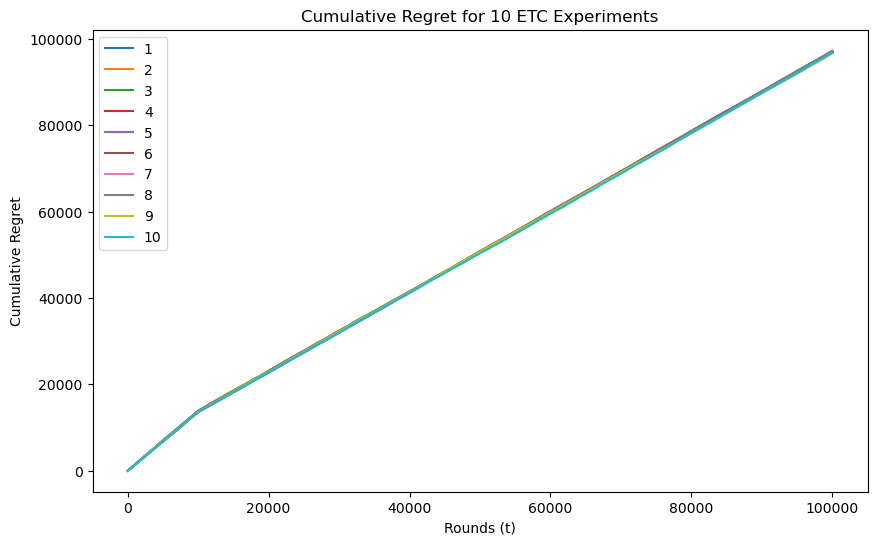

In [35]:
plt.figure(figsize=(10, 6))
for i in range(num_experiments):
    plt.plot(all_cumulative_regrets[i], label=f'{i+1}')
plt.xlabel('Rounds (t)')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret for 10 ETC Experiments')
plt.legend()
plt.show()

Answer for question1: we have slightly different values for cumulative regrets(although it's not obvious on the plot)

In [51]:
num_experiments = 100
n = 100000

all_cumulative_regrets = []
for _ in range(num_experiments):
    cumulative_regret = etc(arms_rewards_df, n)
    all_cumulative_regrets.append(cumulative_regret)

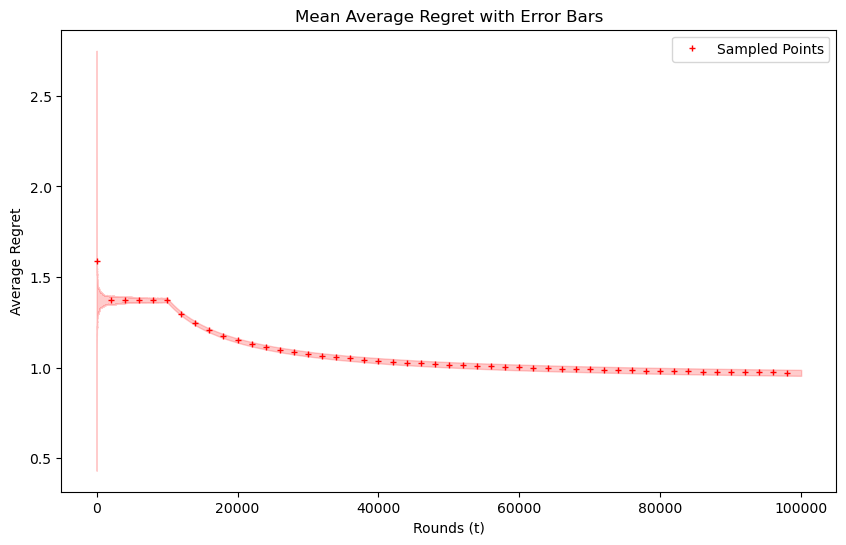

In [52]:
all_cumulative_regrets = np.array(all_cumulative_regrets)

mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regret = np.std(all_cumulative_regrets, axis=0)

average_regret = mean_cumulative_regret / np.arange(1, n + 1)
std_average_regret = std_cumulative_regret / np.arange(1, n + 1)

sampling_interval = 2000
sampled_x = np.arange(0, n, sampling_interval)
sampled_average_regret = average_regret[::sampling_interval]

plt.figure(figsize=(10, 6))

plt.plot(sampled_x, sampled_average_regret, 'r+', markersize=5, label='Sampled Points')

plt.fill_between(range(n), average_regret - std_average_regret, average_regret + std_average_regret, color='red', alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Average Regret')
plt.title('Mean Average Regret with Error Bars')

plt.legend()
plt.show()

### Problem 2

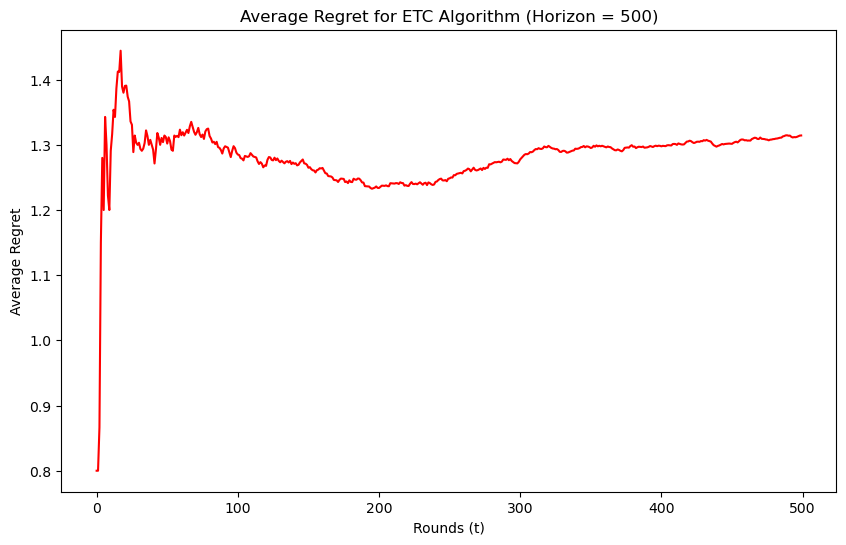

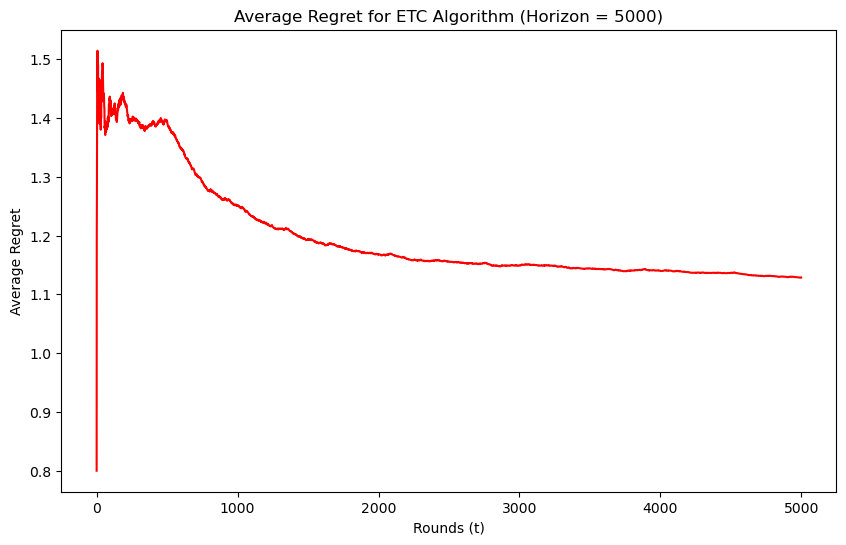

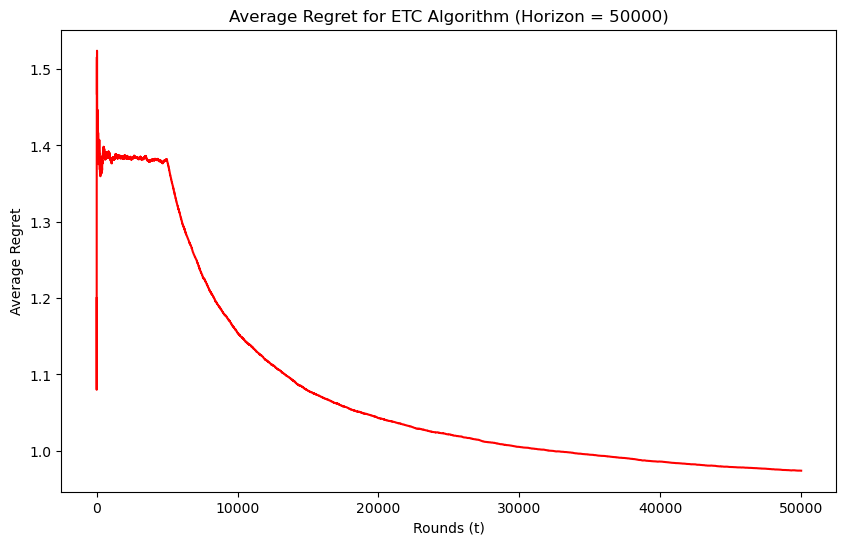

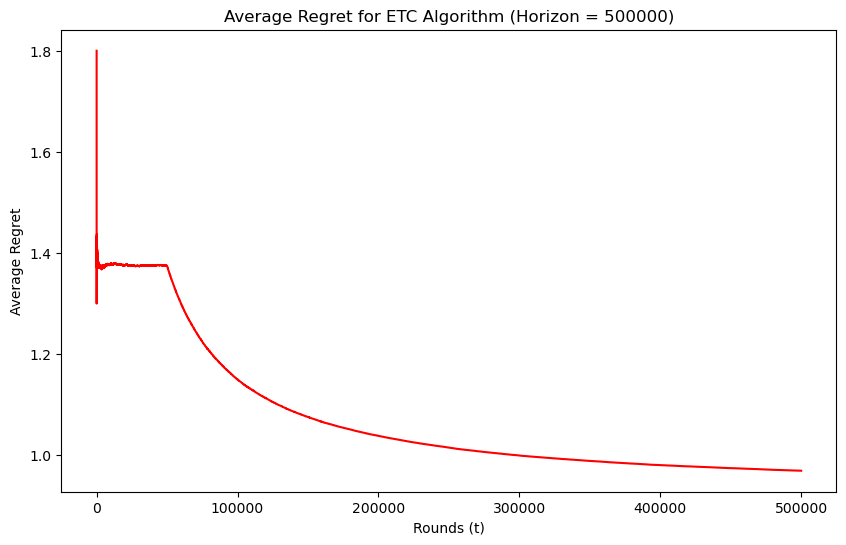

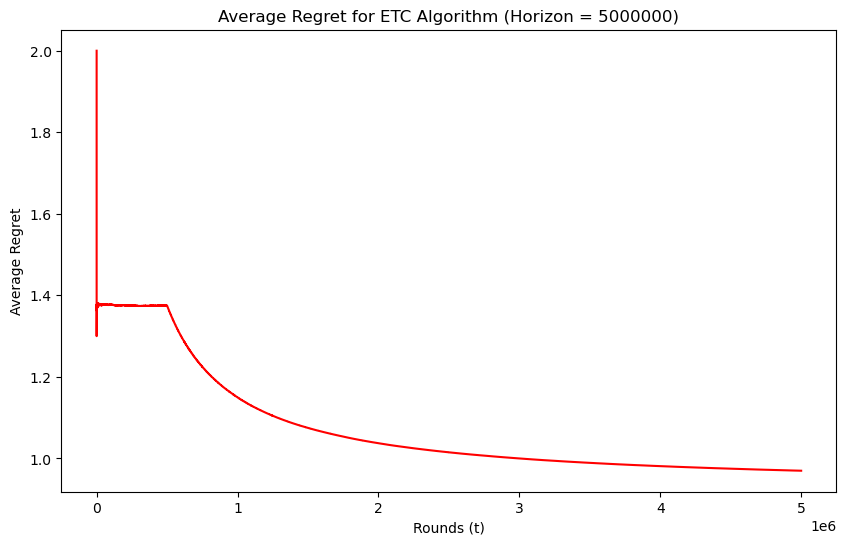

In [50]:
horizons = [500, 5000, 50000, 500000, 5000000]
num_experiments = 100

def run_etc_for_horizon(horizon, arms_rewards_df, num_experiments):
    all_cumulative_regrets = []
    for _ in range(num_experiments):
        cumulative_regret = etc(arms_rewards_df, horizon)
        all_cumulative_regrets.append(cumulative_regret)
    
    all_cumulative_regrets = np.array(all_cumulative_regrets)
    mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
    
    average_regret = mean_cumulative_regret / (np.arange(1, horizon + 1))
    return average_regret

for horizon in horizons:
    avg_regret = run_etc_for_horizon(horizon, arms_rewards_df, num_experiments)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_regret, color='red')
    
    plt.xlabel('Rounds (t)')
    plt.ylabel('Average Regret')
    plt.title(f'Average Regret for ETC Algorithm (Horizon = {horizon})')
    
    plt.show()


Answer for Problem 2:
As t increases, the average regret decreases in commit phase and shows a logarithmic trend for larger horizons. As n goes larger, it seems to be more stable and turns to be a smaller average regret

### Problem 3

In [61]:
n = 100000
num_experiments = 100
exploration_lengths = [100 / 100000, 1000 / 100000, 10000 / 100000, 20000 / 100000]

def run_etc_for_exploration_length(exploration_length, arms_rewards_df, n, num_experiments):
    all_cumulative_regrets = []
    for _ in range(num_experiments):
        cumulative_regret = etc(arms_rewards_df, n, exploration_length)
        all_cumulative_regrets.append(cumulative_regret)
    
    all_cumulative_regrets = np.array(all_cumulative_regrets)
    
    mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
    std_cumulative_regret = np.std(all_cumulative_regrets, axis=0)
    
    average_regret = mean_cumulative_regret / np.arange(1, n + 1)
    std_average_regret = std_cumulative_regret / np.arange(1, n + 1)
    
    return average_regret, std_average_regret

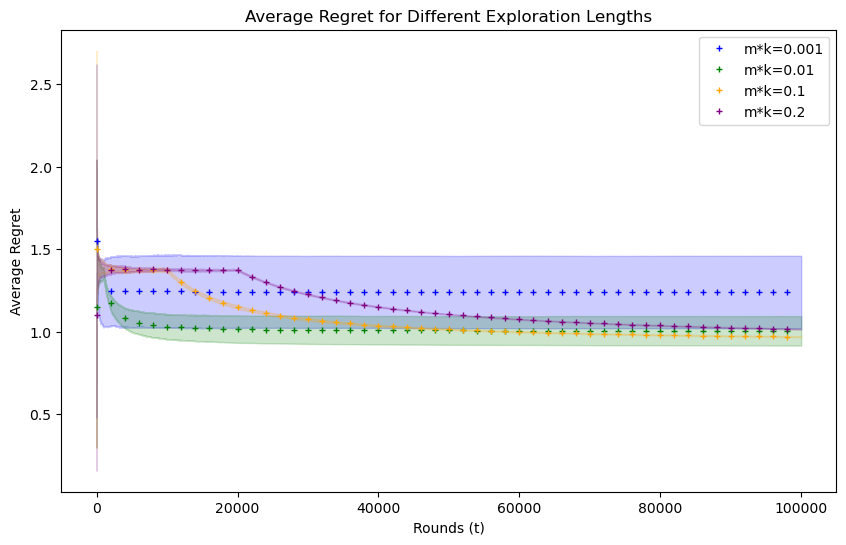

In [62]:
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'orange', 'purple']
labels = [f'm*k={exploration_length}' for exploration_length in exploration_lengths]

for idx, exploration_length in enumerate(exploration_lengths):
    avg_regret, std_avg_regret = run_etc_for_exploration_length(exploration_length, arms_rewards_df, n, num_experiments)
    
    sampling_interval = 2000
    sampled_x = np.arange(0, n, sampling_interval)
    sampled_avg_regret = avg_regret[::sampling_interval]

    plt.plot(sampled_x, sampled_avg_regret, '+', color=colors[idx], markersize=5, label=labels[idx])
    plt.fill_between(range(n), avg_regret - std_avg_regret, avg_regret + std_avg_regret, color=colors[idx], alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Average Regret')
plt.title('Average Regret for Different Exploration Lengths')

plt.legend()
plt.show()

Answer to question 3: It's aligned with theory that yellow line is the best choice for m, which calls a middle number of exploration and commit the result. Spend too much on exploration accumulated too many regret that cannot be allevated during commit process(We should show too many sub-optimal choices to users) despite its low variance. On the contrary, too few eploration like the blue line suggest we are not confident for the estimated result, as is showed by the large shaded blue area in this plot.